In [1]:
import numpy as np
import deepdish as dd
import Plot
import math as m
Plot.Load_RC()

%load_ext Cython
%matplotlib inline 

In [2]:
d = dd.io.load('DeLucia.hdf5')
pos = d['pos']

In [3]:
index = np.arange(len(pos))
index = np.random.choice(index, size=5000, replace=False)
pos = pos[index]

In [4]:
Lbox = 62.5

In [5]:
xmin, xmax, Nbins = -2.0, 1.0, 30
dlogr = (xmax-xmin)/float(Nbins)
logr = np.linspace(xmin, xmax, Nbins,endpoint=False)+dlogr/2


In [6]:
def DR(NBin = 30,Xmin = -2,Xmax = 1,Lbox = 62.5,Ng=100):
    dr = []
    for i in range(NBin):
        Min = 10**(Xmin+i/float(NBin)*(Xmax-Xmin))
        Max = 10**(Xmin+(i+1)/float(NBin)*(Xmax-Xmin))
        Vol = 4./3.*3.1415926*((Max**3)-(Min**3))
        Den = Ng*Lbox**(-3)
        dr.append(Vol*Den*Ng)
    return np.array(dr)

In [7]:
%%time
def DD_python(pos,Nbins = 30,xmin = -2,xmax = 1,Lbox = 62.5):
    DD = np.zeros(Nbins)
    Ng = len(pos)
    for i in range(Ng):
        for j in range(i+1, Ng):
            dx = abs(pos[i][0]-pos[j][0])
            dy = abs(pos[i][1]-pos[j][1]) 
            dz = abs(pos[i][2]-pos[j][2])
            
            if (dx > 0.5*Lbox): dx = Lbox - dx
            if (dy > 0.5*Lbox): dy = Lbox - dy
            if (dz > 0.5*Lbox): dz = Lbox - dz

            dlogdist = 0.5 * m.log10(dx*dx + dy*dy + dz*dz+1e-10)
            index = int((dlogdist - xmin) / dlogr)
            if(index >= 0 and index < Nbins): DD[index] += 1
    return DD
DD_p = DD_python(pos,Nbins,xmin,Lbox)
Xi_p = 2*DD_p/DR(Nbins,xmin,xmax,Lbox,len(pos))-1

CPU times: user 30.6 s, sys: 80 ms, total: 30.7 s
Wall time: 30.5 s


In [13]:
%%cython
import numpy as np
import math as m
cdef extern from "<math.h>":
        double log10(double x)
def DD_cython(double[:, :] pos,int Nbins = 30, float xmin = -2, float xmax = 1,float Lbox = 62.5):   
    cdef double dlogr = (xmax-xmin)/Nbins
    cdef long[:] DD = np.zeros(Nbins, dtype=int)
    
    cdef double dx, dy, dz, dlogdist
    cdef int i, j, index
    
    for i in range(len(pos)):
        for j in range(i+1, len(pos)):
            dx = abs(pos[i][0]-pos[j][0])
            dy = abs(pos[i][1]-pos[j][1]) 
            dz = abs(pos[i][2]-pos[j][2])
            
            if (dx > 0.5*Lbox): dx = Lbox - dx
            if (dy > 0.5*Lbox): dy = Lbox - dy
            if (dz > 0.5*Lbox): dz = Lbox - dz

            dlogdist = 0.5 * log10(dx*dx + dy*dy + dz*dz+1e-10)
            index = int((dlogdist - xmin) / dlogr)
            if(index >= 0 and index < Nbins): DD[index] += 1
    return np.array(DD)

In [14]:
%%time
DD_c = DD_cython(pos,Nbins,xmin,Lbox)
Xi_c = 2*DD_p/DR(Nbins,xmin,xmax,Lbox,len(pos))-1

CPU times: user 1.6 s, sys: 0 ns, total: 1.6 s
Wall time: 1.6 s


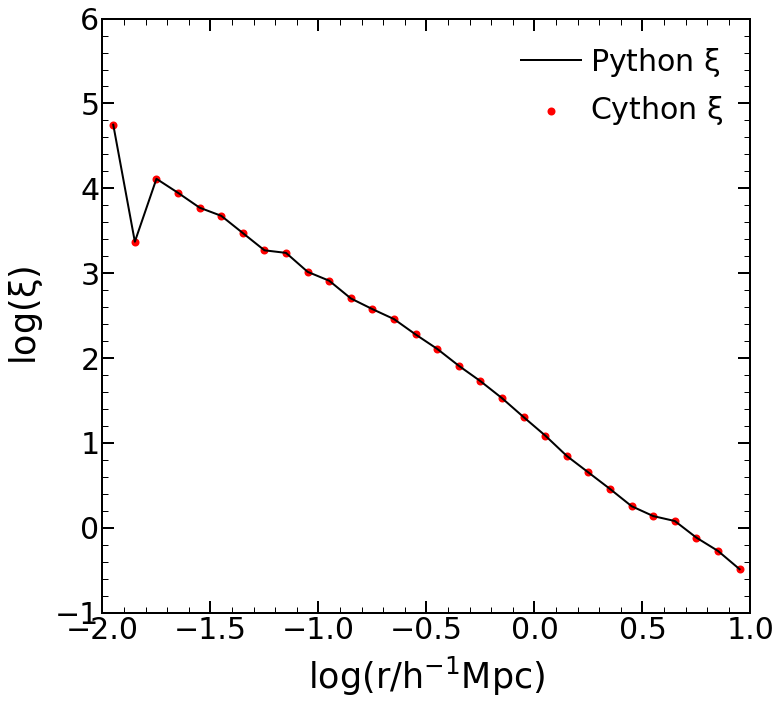

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot():    
    fig,ax0 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    gs = gridspec.GridSpec(1, 1)
    gs.update(hspace=0.0)
    ax = plt.subplot(gs[0,0])

    ax.plot(logr     ,np.log10(Xi_p),color =  'k', ls='-', linewidth=2, label=r'$\rm Python\ \xi$')  
    ax.scatter(logr     ,np.log10(Xi_c),c =  'r', linewidth=2, label=r'$\rm Cython\ \xi$')  
    #ax.plot(logr[:-1],np.log10(Xi_h),color =  'b', ls=':', linewidth=2, label=r'$\rm Halotools\ \xi$')        
    ax.legend(loc='upper right', shadow=True,fontsize=30,frameon=False) 
    ####################################################################################################
    ax.set_xlim([-2, 1])
    ax.set_ylim([-1, 6])
    ####################################################################################################
    ax.set_xlabel(r'$\rm log(r/h^{-1}Mpc)$', fontsize=35)
    ax.set_ylabel(r'$\rm log(\xi)$', fontsize=35)
plot()


In [11]:
import halotools.mock_observables as htools
Xi_h = htools.tpcf(pos, 10**(logr-dlogr/2), period=Lbox)

/home/sergio/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


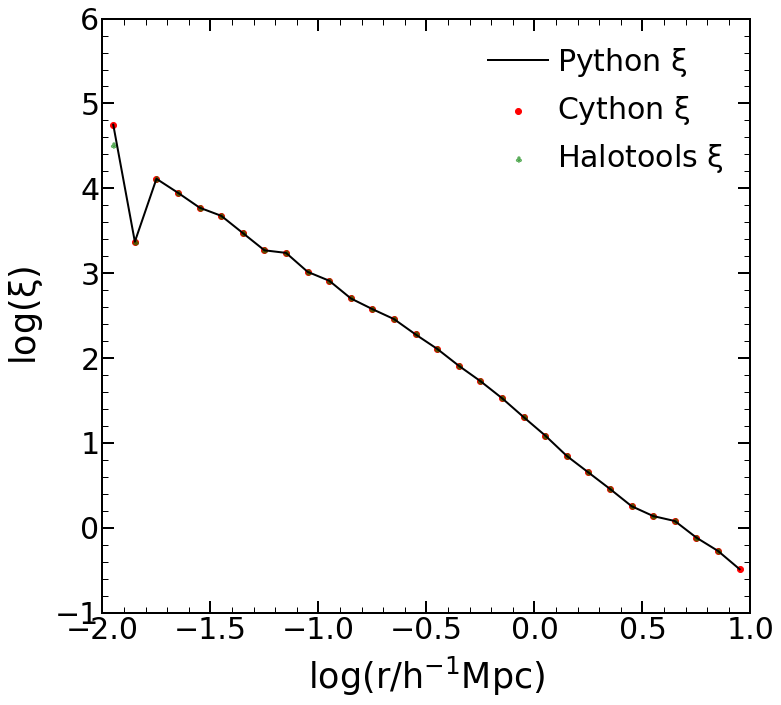

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot():    
    fig,ax0 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    gs = gridspec.GridSpec(1, 1)
    gs.update(hspace=0.0)
    ax = plt.subplot(gs[0,0])

    ax.plot(logr     ,np.log10(Xi_p),color =  'k', ls='-', linewidth=2, label=r'$\rm Python\ \xi$')  
    ax.scatter(logr     ,np.log10(Xi_c),c =  'r',label=r'$\rm Cython\ \xi$')  
    ax.scatter(logr[:-1],np.log10(Xi_h), c="g", alpha=0.5, marker=r'$\clubsuit$' ,label=r'$\rm Halotools\ \xi$')        
    ax.legend(loc='upper right', shadow=True,fontsize=30,frameon=False) 
    ####################################################################################################
    ax.set_xlim([-2, 1])
    ax.set_ylim([-1, 6])
    ####################################################################################################
    ax.set_xlabel(r'$\rm log(r/h^{-1}Mpc)$', fontsize=35)
    ax.set_ylabel(r'$\rm log(\xi)$', fontsize=35)
plot()
